# Init

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
from tqdm import tqdm

from pprint import pprint
import time
from IPython.display import clear_output


if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [3]:
def random_policy(nA):
    return np.ones(nA) / nA

In [4]:
def choose_step(policy, state):
    action_probs = policy(state)
    return np.random.choice(np.arange(len(action_probs)), p=action_probs)

In [5]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in tqdm(range(num_episodes)):
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            action = choose_step(policy, state)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state
    
    return Q, stats

In [6]:
def Q_decision_map(env, Q):
    outfile = sys.stdout
    
    for i in range(env.rows):
        outfile.write("|")
        for j in range(env.cols):
            pos = (i,j)
            if pos not in Q:
                outfile.write("?")
            else:
                action = np.argmax(Q[pos])
                symbols = ["↑", "↟", "↖", "↗"]
                outfile.write(symbols[action])
        outfile.write("|\n")

In [7]:
def animate(policy):
    state = env.reset()

    done = False
    reward = 0
    for i in range(env.rows):
        clear_output(wait=True)
        env.render()
        if done:
            break
        state, reward, done, _ = env.step(choose_step(policy, state))
        time.sleep(0.2)

    print("End state reward: %d" % reward)

# Sanity check

In [8]:
from lib.envs.highway import HighwayEnv, Actions
env = HighwayEnv(
    drunk_column=5,
    other_column=-1,
    reward_crash=0,
    reward_missed=0,
    reward_success=10,
    reward_safe=0,
    pb_slow_left=0,
    pb_slow_right=0,
    pb_fast_left=0,
    pb_fast_right=0
)

In [9]:
Q, stats = q_learning(env, 
    num_episodes=5000, 
    discount_factor=1, 
    alpha=1, 
    epsilon=0.1)

100%|██████████| 5000/5000 [00:04<00:00, 1088.17it/s]


In [10]:
Q_decision_map(env, Q)

|??↑↑↑?|
|??↑↑↗↑|
|??↑↗↑↑|
|??↑↑↑↑|
|??↑↟↑↑|
|??↑↑↑↑|
|???↑↑↑|
|???↑↑↑|
|????↑↑|
|?????↑|


In [17]:
animate(make_epsilon_greedy_policy(Q, epsilon=0, nA=env.action_space.n))

|.....X|
|....x.|
|......|
|......|
|......|
|......|
End state reward: 10


In [12]:
pprint(Q)

defaultdict(<function q_learning.<locals>.<lambda> at 0x7fc4424de598>,
            {-3: array([ 0.,  0.,  0.,  0.]),
             -2: array([ 0.,  0.,  0.,  0.]),
             -1: array([ 0.,  0.,  0.,  0.]),
             (0, 1): array([ 0.,  0.,  0.,  0.]),
             (0, 2): array([ 0.,  0.,  0.,  0.]),
             (0, 3): array([ 0.,  0.,  0.,  0.]),
             (0, 4): array([ 0.,  0.,  0.,  0.]),
             (1, 2): array([ 0.,  0.,  0.,  0.]),
             (1, 3): array([ 0.,  0.,  0.,  0.]),
             (1, 4): array([  0.,   0.,   0.,  10.]),
             (1, 5): array([ 10.,   0.,   0.,   0.]),
             (2, 2): array([ 0.,  0.,  0.,  0.]),
             (2, 3): array([ 0.,  0.,  0.,  0.]),
             (2, 4): array([ 10.,   0.,   0.,  10.]),
             (2, 5): array([ 10.,  10.,  10.,   0.]),
             (3, 2): array([ 0.,  0.,  0.,  0.]),
             (3, 3): array([  0.,   0.,   0.,  10.]),
             (3, 4): array([ 10.,  10.,   0.,  10.]),
             (3, 

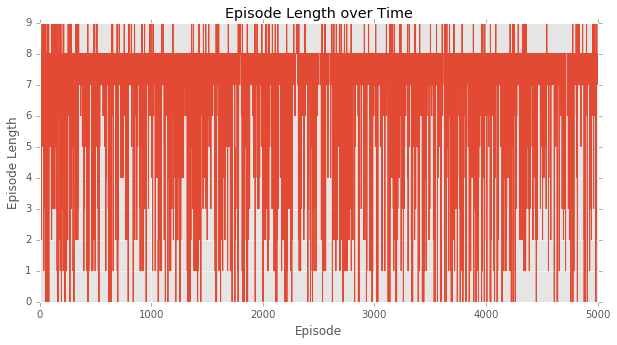

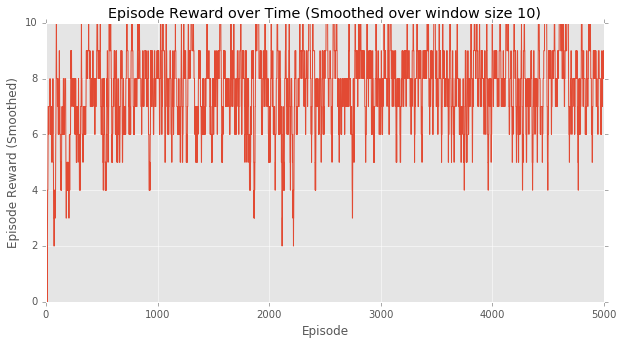

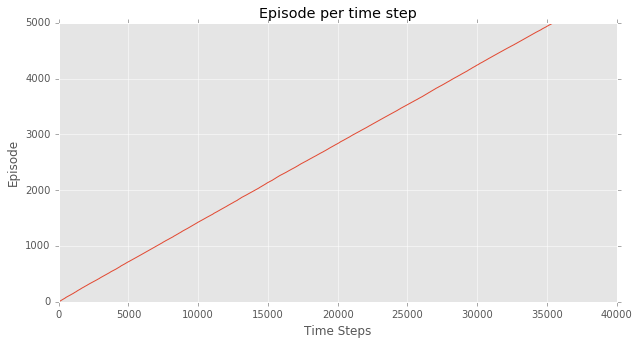

(<matplotlib.figure.Figure at 0x7f0995908a20>,
 <matplotlib.figure.Figure at 0x7f098dc0dd68>)

In [13]:
plotting.plot_episode_stats(stats)

# Original example

In [15]:
from lib.envs.highway import HighwayEnv, Actions
env = HighwayEnv(
    rows=6,
    drunk_column=3,
    other_column=4,
    reward_crash=-100,
    reward_missed=0,
    reward_success=10,
    reward_safe=0,
    pb_slow_left=0.1,
    pb_slow_right=0.1,
    pb_fast_left=0,
    pb_fast_right=0
)

In [16]:
Q, stats = q_learning(env, 
    num_episodes=10000, 
    discount_factor=1,
    alpha=1, 
    epsilon=0.1)

100%|██████████| 10000/10000 [00:04<00:00, 2076.98it/s]


In [136]:
Q_decision_map(env, Q)

|↟↑↑↑↑?|
|↟↑↑↑↗↟|
|↟↑↑↗↑?|
|?↑↑↑??|
|??↑↟??|
|???↟??|


In [143]:
animate(make_epsilon_greedy_policy(Q, epsilon=0, nA=env.action_space.n))

|.....X|
|....x.|
|......|
|......|
|......|
|......|
End state reward: 10


In [52]:
pprint(Q)

defaultdict(<function q_learning.<locals>.<lambda> at 0x7fc44009e620>,
            {-3: array([ 0.,  0.,  0.,  0.]),
             -2: array([ 0.,  0.,  0.,  0.]),
             -1: array([ 0.,  0.,  0.,  0.]),
             (0, 0): array([-100.,    0., -100.,    0.]),
             (0, 1): array([ 0.,  0.,  0.,  0.]),
             (0, 2): array([ 0.,  0.,  0.,  0.]),
             (0, 3): array([ 0.,  0.,  0.,  0.]),
             (0, 4): array([ 0.,  0.,  0.,  0.]),
             (1, 0): array([-100.,    0., -100.,    0.]),
             (1, 1): array([ 0.,  0.,  0.,  0.]),
             (1, 2): array([ 0.,  0.,  0.,  0.]),
             (1, 3): array([ 0.,  0.,  0.,  0.]),
             (1, 4): array([   0.,    0.,    0.,  100.]),
             (1, 5): array([-100.,    0.,    0., -100.]),
             (2, 0): array([   0.,    0., -100.,    0.]),
             (2, 1): array([ 0.,  0.,  0.,  0.]),
             (2, 2): array([ 0.,  0.,  0.,  0.]),
             (2, 3): array([   0.,    0.,    0.,  1

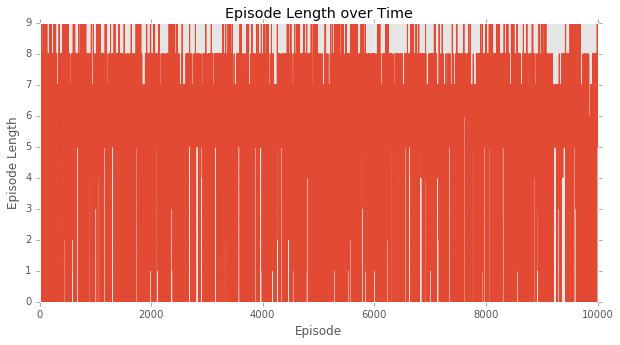

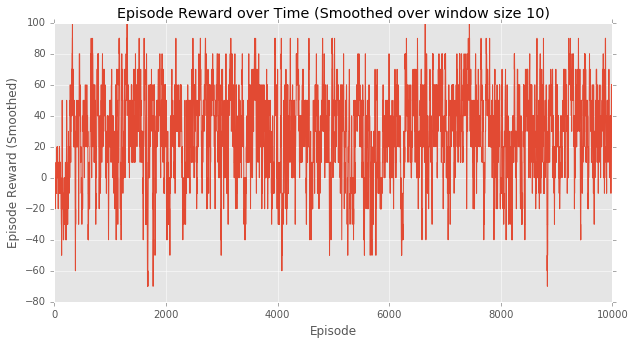

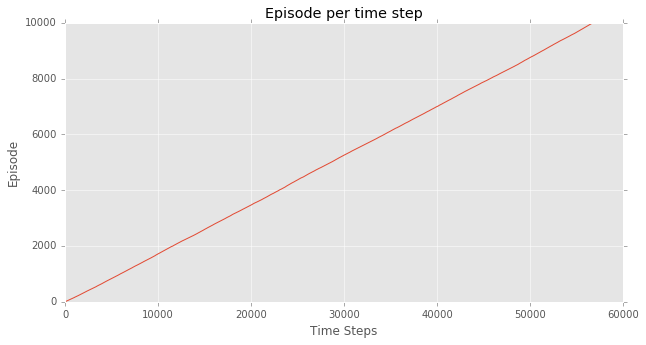

(<matplotlib.figure.Figure at 0x7fc4400e3be0>,
 <matplotlib.figure.Figure at 0x7fc4383f3b00>)

In [53]:
plotting.plot_episode_stats(stats)